In [ ]:
## IMPORTS ##

import os
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from scipy.linalg import kron

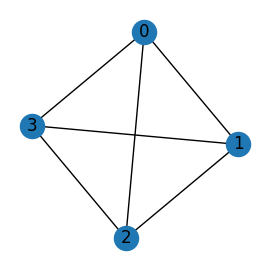

In [ ]:
## GENERATE RANDOM GRAPH ##

N = 4  # number of nodes
p = 1  # probability of creating edge

# generate random graph
G = nx.erdos_renyi_graph(N, p)

# visualize graph
plt.figure(figsize=(2.5, 2.5))
nx.draw(G, with_labels=True)
plt.show()

In [ ]:
## CALCULATE A FROM GRAPH ##

adj_matrix = nx.adjacency_matrix(G).todense()

def get_A(adj_matrix):
    """
    This function works given the following assumptions on the adjacency matrix:
        1. square
        2. symmetric (graph is undirected)
        3. binary
    """

    N_agents = adj_matrix.shape[0]  # num agents
    A = np.zeros((2*N_agents, 2*N_agents)) # size of A will be 2*size of adj_matrix (to account for shared and local layers)

    for i in range(N_agents):
        agent_num = i + 1 # makes the math easier

        # update local layer row (only depends on itself)
        local_layer_index = (2 * agent_num) - 1
        A[local_layer_index, local_layer_index] = 1

        # update shared layer row
        for j in range(N_agents):
            constant = np.count_nonzero(adj_matrix[i, :]) + 1 # number of connections agent i has including itself
            shared_layer_index = 2 * (agent_num - 1)
            if adj_matrix[i, j] == 1 or j == i:
                A[shared_layer_index, 2 * (j - 1)] = 1/constant
    return A

A = get_A(adj_matrix)

In [ ]:
## DEFINE NEURAL NETWORK ARCHITECTURE ##

# shared layers only
class SharedNet(nn.Module):
    def __init__(self):
        super(SharedNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        shape_before_flatten = x.shape
        x = x.view(-1, 32 * shape_before_flatten[2] * shape_before_flatten[3])
        return x, shape_before_flatten

# task-specific model
class Agent(nn.Module):
    def __init__(self, shared_net, output_dim):
        super(Agent, self).__init__()
        self.shared = shared_net
        self.task_specific = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64*2*2, output_dim)
        )

    def forward(self, x):
        x, shape_before_flatten = self.shared(x)
        x = x.view(shape_before_flatten)
        x = self.task_specific(x)
        return x

## EXAMPLE WITH MNIST ##

In [ ]:
## LOAD MNIST DATA ##

# set up data loading for MNIST
#transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

transform = transforms.Compose([
    transforms.Resize(16),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# load train and test sets
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# split into task specific datasets
trainset_agent = [[(x, y) for x, y in trainset if y < 5], [(x, y - 5) for x, y in trainset if y >= 5]]

# set up data loaders
trainloader_agent = []
for trainset in trainset_agent:
    trainloader_agent.append(DataLoader(trainset, batch_size=32, shuffle=True))

100%|██████████| 9912422/9912422 [00:00<00:00, 83233823.97it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 31036560.04it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 22905460.16it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21623755.70it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# # Calculate training and validation sizes for each agent's data
# train_size_agent1 = int(0.8 * len(trainset_agent[0]))
# val_size_agent1 = len(trainset_agent[0]) - train_size_agent1

# train_size_agent2 = int(0.8 * len(trainset_agent[1]))
# val_size_agent2 = len(trainset_agent[1]) - train_size_agent2

# # Split the data
# train_dataset_agent1, val_dataset_agent1 = torch.utils.data.random_split(trainset_agent[0], [train_size_agent1, val_size_agent1])
# train_dataset_agent2, val_dataset_agent2 = torch.utils.data.random_split(trainset_agent[1], [train_size_agent2, val_size_agent2])

# # Create DataLoader for validation sets
# valloader_agent1 = DataLoader(val_dataset_agent1, batch_size=32, shuffle=False)
# valloader_agent2 = DataLoader(val_dataset_agent2, batch_size=32, shuffle=False)


In [ ]:
class CustomOpt(torch.optim.Optimizer):
    def __init__(self, params, A, E, lr=0.01):
        defaults = dict(lr=lr)
        self.A = A
        self.E = E
        self.lr = lr/E

        self.weights_store = None
        self.psi = None
        self.old_psi = None
        self.phi = None

        self.param_info = None

        super(CustomOpt, self).__init__(params, defaults)

    def setup_params(self):
        param_vector = []
        grad_vector = []
        #param_info = []
        all_param_info = []

        for group in self.param_groups:
            flat_params = [param.view(-1) for param in group['params']]
            flat_grads = [param.grad.view(-1) for param in group['params']]
            param_info = []
            start_idx = 0

            for param, flat_param in zip(group['params'], flat_params):
                end_idx = start_idx + flat_param.size(0)
                param_info.append((param, start_idx, end_idx, param.size()))
                start_idx = end_idx

            concat_params = torch.cat(flat_params)
            concat_grads = torch.cat(flat_grads)
            param_vector.append(concat_params)
            grad_vector.append(concat_grads)
            all_param_info.append(param_info)

        max_length = max([tensor.size(0) for tensor in param_vector])

        param_vector = [torch.nn.functional.pad(tensor, (0, max_length - tensor.size(0))) for tensor in param_vector]
        grad_vector = [torch.nn.functional.pad(tensor, (0, max_length - tensor.size(0))) for tensor in grad_vector]

        param_matrix = torch.stack(param_vector)
        grad_matrix = torch.stack(grad_vector)

        return param_matrix, grad_matrix, all_param_info

    def putback_params(self, updated_params_matrix, all_param_info):
        for group_idx, param_info_list in enumerate(all_param_info):
          updated_values_group = updated_params_matrix[group_idx]

          for param_info in param_info_list:
              param, start_idx, end_idx, original_shape = param_info
              updated_values = updated_values_group[start_idx:end_idx]
              param.data = updated_values.view(original_shape)

    def local_step(self):
        # set up params
        param_matrix, grad_matrix, param_info = self.setup_params()

        if self.param_info == None:
            self.param_info = param_info # should always be the same, therefore only assign it once

        # if it is the first loop of E, save the current iteration's weights to be used to update phi at the end of the E loop
        if self.weights_store == None:
            self.weights_store = param_matrix.clone()

        # update one E step
        param_matrix = param_matrix - self.lr * grad_matrix
        self.psi = param_matrix.clone().detach()

        # put back params
        self.putback_params(param_matrix, param_info)

    def correct(self):
        if self.old_psi == None:
            phi = self.psi.clone().detach()
        else:
            phi = self.weights_store + self.psi - self.old_psi

        # store new old_psi
        self.old_psi = self.psi.clone().detach()

        # reset weights_store for next epoch
        self.weights_store = None

        # store phi to update weights
        self.phi = phi.clone().detach()

    def step(self):
        # update weights+biases
        torch_A = torch.from_numpy(self.A).float()
        torch_A = 0.5 * (torch_A + torch.eye(torch_A.size(0)))
        updated_params_matrix = torch.matmul(torch_A, self.phi)

        # put back params
        self.putback_params(updated_params_matrix, self.param_info)
        return 1

In [ ]:
# initialize full task-specific networks (N copies of shared + local network architecture)
shared_networks = []
agent_networks = []
for n in range(N):
    shared_net = SharedNet()
    shared_networks.append(shared_net)
    agent_networks.append(Agent(shared_net, 5)) # 5 output classes to demonstrate with MNIST data

In [ ]:
param_list = []
E = 2

for network in agent_networks:
    param_list.append({'params': network.shared.parameters()})
    param_list.append({'params': network.task_specific.parameters()})

optimizer = CustomOpt(param_list, A, E, lr=0.0025)
criterion = nn.CrossEntropyLoss()

In [ ]:
agent1_losses = []
agent2_losses = []
agent3_losses = []
agent4_losses = []

agent1_gradients = []
agent2_gradients = []
agent3_gradients = []
agent4_gradients = []

num_epochs = 50

for epoch in range(num_epochs):
    agent1_loss = 0.0
    agent2_loss = 0.0
    agent3_loss = 0.0
    agent4_loss = 0.0
    num_batches = 0

    for (inputs1, labels1), (inputs2, labels2) in zip(trainloader_agent[0], trainloader_agent[1]):
        agent1 = agent_networks[0]
        agent2 = agent_networks[1]
        agent3 = agent_networks[2]
        agent4 = agent_networks[3]

        optimizer.zero_grad()

        # e loop
        for e in range(E):

            optimizer.zero_grad()
            outputs1 = agent1(inputs1)
            outputs2 = agent2(inputs2)
            outputs3 = agent3(inputs1)
            outputs4 = agent4(inputs2)

            loss1 = criterion(outputs1, labels1)
            loss2 = criterion(outputs2, labels2)
            loss3 = criterion(outputs3, labels1)
            loss4 = criterion(outputs4, labels2)

            total_loss = loss1 + loss2 + loss3 + loss4
            total_loss.backward()

            optimizer.local_step()

        # correction
        optimizer.correct()

        optimizer.step()

        agent1_loss += loss1.item()
        agent2_loss += loss2.item()
        agent3_loss += loss3.item()
        agent4_loss += loss4.item()
        num_batches += 1

    agent1_loss /= num_batches
    agent2_loss /= num_batches
    agent1_losses.append(agent1_loss)
    agent2_losses.append(agent2_loss)

    agent3_loss /= num_batches
    agent4_loss /= num_batches
    agent3_losses.append(agent3_loss)
    agent4_losses.append(agent4_loss)

    print(f'Epoch {epoch+1}, Agent1 Loss: {agent1_loss}, Agent2 Loss: {agent2_loss}, Agent3 Loss: {agent3_loss}, Agent4 Loss: {agent4_loss}')

# plot log loss instead:
plt.figure(figsize=(10, 7))

# Take 10*log10 of the losses
agent1_losses_log = 10 * np.log10(agent1_losses)
agent2_losses_log = 10 * np.log10(agent2_losses)
agent3_losses_log = 10 * np.log10(agent3_losses)
agent4_losses_log = 10 * np.log10(agent4_losses)

# Plot the transformed losses
plt.plot(range(num_epochs), agent1_losses_log, label='Agent 1 Loss (10*log10)')
plt.plot(range(num_epochs), agent2_losses_log, label='Agent 2 Loss (10*log10)')
plt.plot(range(num_epochs), agent3_losses_log, label='Agent 3 Loss (10*log10)')
plt.plot(range(num_epochs), agent4_losses_log, label='Agent 4 Loss (10*log10)')

plt.xlabel('Epochs')
plt.ylabel('Loss (10*log10)')
plt.legend()
plt.show()

# Plotting validation losses
# plt.figure(figsize=(10, 7))
# agent1_val_losses, agent2_val_losses = zip(*val_losses)
# plt.plot(range(num_epochs), agent1_val_losses, label='Validation Agent 1 Loss')
# plt.plot(range(num_epochs), agent2_val_losses, label='Validation Agent 2 Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Validation Loss')
# plt.legend()
# plt.show()

In [ ]:
import pickle

with open("primal_dual_mnist.pkl", "wb") as file:
  pickle.dump((agent1_losses, agent2_losses, agent3_losses, agent4_losses), file)
